# Seq2Seq model for each frequency

In [115]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [ ]:
# Print torch version
print(f"PyTorch version: {torch.__version__}")

# Print device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

PyTorch version: 2.4.1+cu121


## Load Data

In [116]:
path = r'TF_HLC'

In [117]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq_200.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_200.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_200.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

print(TTF_data.shape, Vs_data.shape,freq_data.shape)

# Convert freq_data to 1000,2000 vector
#freq_vals = np.repeat(np.expand_dims(freq_data, axis=0), 1000, axis=0)
freq_vals = freq_data
print(freq_vals.shape)


(1000, 200) (1000, 29) (200,)
(200,)


In [118]:
def text_plot(Vs):
    # Eliminate the nan at the end of the array
    Vs = Vs[~np.isnan(Vs)]
    vs_soil = Vs[0]
    h_soil = len(Vs[:-1]) * 5
    vs_bedrock = Vs[-1]
    return f"Vs soil: {vs_soil:.0f} m/s\nVs bedrock: {vs_bedrock:.0f} m/s\nh soil: {h_soil} m\nfreq_calc: {vs_soil/(4*(h_soil+5)):.2f} Hz"

def freq_calc(Vs):
    # Eliminate the nan at the end of the array
    Vs = Vs[~np.isnan(Vs)]
    vs_soil = Vs[0]
    h_soil = len(Vs[:-1]) * 5
    return vs_soil/(4*(h_soil+5))


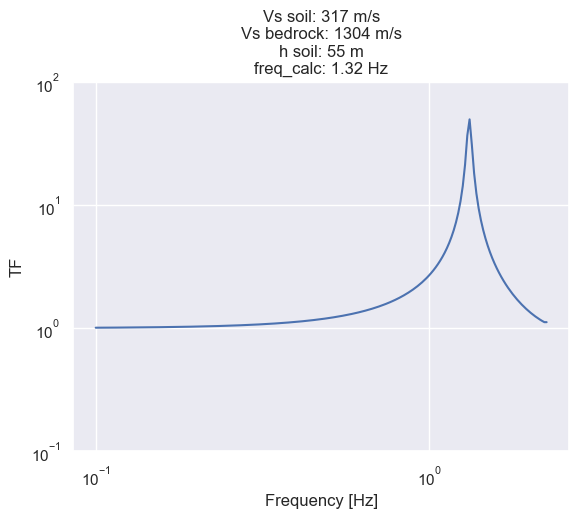

In [119]:
idx = np.random.randint(0,1000)
plt.loglog(freq_data, TTF_data[idx])
plt.title(text_plot(Vs_data[idx]))
plt.xlabel("Frequency [Hz]")
plt.ylabel("TF")
plt.ylim([1e-1, 1e2])
plt.show()

## Create Dataset and DataLoader

In [120]:
freq_vals.shape

(200,)

In [123]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values, freq_values=None):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        self.freq_values = freq_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):
        # Target data
        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        #print(target_data.shape)
        # Input data
        input_data = torch.tensor(self.Vs_values[idx], dtype=torch.float32)
        #input_data = torch.repeat_interleave(input_data, target_data.shape[0], dim=0).unsqueeze(1)
        #print(input_data.shape)

        input_data = torch.nan_to_num(input_data, nan=0.0, posinf=0.0, neginf=0.0)

        
        return input_data, target_data

In [124]:
dataset = TTF_dataset(TTF_data, Vs_data, freq_values=None)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)

Sizes in the dataset:  1000
Data shapes for input and target:  torch.Size([29]) torch.Size([200])


In [125]:
# Separate into training and testing
train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " , train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))
print("Training shapes: ", next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)

Train, validation and test sizes:  700 150 150
Number of batches:  70 15 15
Training shapes:  torch.Size([10, 29]) torch.Size([10, 200])


## Create Model

In [126]:
X, y = next(iter(train_loader))
print(X.shape, y.shape)

torch.Size([10, 29]) torch.Size([10, 200])


### CNN1D

In [127]:
class CNN1D(nn.Module):
    def __init__(self, input_channels, output_size, n_layers=3, n_filters=16, kernel_size=3):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=3)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*3, 128)
        self.fc2 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        batch_size, sequence_length, input_channels, features_size = x.shape
        x = x.reshape(-1, input_channels, features_size)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        #print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.reshape(batch_size, sequence_length, -1).squeeze(-1)
        return x

### LSTM

In [128]:
# Define the Encoder LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        out, (h1, c1) = self.lstm(x, (h0, c0))
        return out, (h1, c1)

In [129]:
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional_encoder=False):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional_encoder = bidirectional_encoder
        self.num_directions = 2 if bidirectional_encoder else 1
        self.lstm = nn.LSTM(input_size, hidden_size * self.num_directions, num_layers, batch_first=True)

    def forward(self, x, hidden):
        if self.bidirectional_encoder:
            # Concatenate the hidden states from both directions
            h0, c0 = hidden
            h0 = h0.view(self.num_layers, self.num_directions, -1, self.hidden_size)
            c0 = c0.view(self.num_layers, self.num_directions, -1, self.hidden_size)
            h0 = torch.cat((h0[:, 0, :, :], h0[:, 1, :, :]), dim=2)
            c0 = torch.cat((c0[:, 0, :, :], c0[:, 1, :, :]), dim=2)
            h0 = h0.view(self.num_layers, -1, self.hidden_size * 2)
            c0 = c0.view(self.num_layers, -1, self.hidden_size * 2)
            hidden = (h0, c0)
        out, hidden = self.lstm(x, hidden)
        return out, hidden


## MLP

In [130]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [132]:
model = MLP(input_dim=29, hidden_dim=64, hidden_layers=3, output_dim=200, activation=nn.ReLU, batch_norm=False)

model(X).shape

torch.Size([10, 200])

In [131]:
import torch
import torch.nn as nn

class TransferFunctionModel(nn.Module):
    def __init__(self, num_depths, num_frequencies):
        super(TransferFunctionModel, self).__init__()
        
        # 1D Convolutional layers to process depth-dependent material properties
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Global average pooling to reduce spatial dimensions
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # LSTM to process frequency-dependent behavior
        self.lstm = nn.LSTM(input_size=65, hidden_size=128, num_layers=2, batch_first=True)
        
        # Output layer
        self.output_layer = nn.Linear(128, 1)
    
    def forward(self, X):
        material_props, frequencies = X
        batch_size = material_props.size(0)
        
        # Process material properties with 1D convolutions
        # Reshape input: (batch, depths) -> (batch, 1, depths)
        x = material_props.unsqueeze(1)
        x = self.conv_layers(x)
        
        # Global average pooling
        x = self.global_avg_pool(x).squeeze(-1)  # (batch, 64)
        
        # Repeat material features for each frequency
        x_repeated = x.unsqueeze(1).repeat(1, frequencies.size(1), 1) # (batch, frequencies, 64)
        
        # Combine material features with frequencies
        combined = torch.cat([x_repeated, frequencies], dim=2)
        
        # Process with LSTM
        lstm_out, _ = self.lstm(combined)
        
        # Generate output for each frequency
        output = self.output_layer(lstm_out)
        
        return output.squeeze(-1)

# Create the model
model = TransferFunctionModel(num_depths=29, num_frequencies=200)

In [619]:
material_test = torch.randn(100, 29)
freq_test = torch.randn(100, 200, 1)
X = (material_test, freq_test)

# Model
material_proccesor = MLP(29, 64,2,64)
lstm = nn.LSTM(65, 64, 2, batch_first=True)
output_processor = nn.Linear(64, 1)


# Test the model
material_proccesed = material_proccesor(material_test)
print(material_proccesed.shape)
material_proccesed = material_proccesed.unsqueeze(1).repeat(1, 200, 1)
print(material_proccesed.shape)
input_data = torch.cat((material_proccesed, freq_test), dim=2)
print(input_data.shape)

output, (_, _) = lstm(input_data)
print(output.shape)

output = output_processor(output)
print(output.shape)


torch.Size([100, 64])
torch.Size([100, 200, 64])
torch.Size([100, 200, 65])
torch.Size([100, 200, 64])
torch.Size([100, 200, 1])


In [620]:
model = TransferFunctionModel(29, 200, hidden_dim=64)
out = model(X)
print(out.shape)

torch.Size([100, 200])


In [374]:
# Example usage
input_size = 30
hidden_size = 2
num_layers = 5
bidirectional_encoder = False

# MLP
hidden_layers = 3
hidden_dim = 10
output_dim = 1

# Example
X = torch.randn(50, 1, input_size)
encoder = EncoderLSTM(input_size, hidden_size, num_layers, bidirectional_encoder)
decoder = MLP(hidden_size*2 if bidirectional_encoder else hidden_size, hidden_dim, hidden_layers, output_dim)

# Encode the input sequence
encoder_output, (h1, c1) = encoder(X)
print("Encoder output shape:", encoder_output.shape)
print("Encoder hidden state shape:", h1.shape)
print("Encoder cell state shape:", c1.shape)

# Decode the output sequence
decoder_output = decoder(encoder_output)
print("Decoder output shape:", decoder_output.shape)


Encoder output shape: torch.Size([50, 1, 2])
Encoder hidden state shape: torch.Size([5, 50, 2])
Encoder cell state shape: torch.Size([5, 50, 2])
Decoder output shape: torch.Size([50, 1, 1])


In [375]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, mlp, device="cpu", freq_linear=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder.to(device)
        self.mlp = mlp.to(device)

        # LSTM weights for material properties
        self.freq_linear = freq_linear.to(device) if freq_linear is not None else None

    def forward(self, x, print_shapes=False):
        # Separate the data
        material_input, freq_input = x[:, :, :-1], x[:, :, -1].unsqueeze(2)
        if print_shapes:
            print("Material input shape:", material_input.shape)
            print("Frequency input shape:", freq_input.shape)

        # Encode the input sequence
        encoder_output, (h1, c1) = self.encoder(material_input)
        if print_shapes:
            print("Encoder output shape:", encoder_output.shape)
            print("Encoder hidden state shape:", h1.shape)
            print("Encoder cell state shape:", c1.shape)

        # Encode frequency
        if self.freq_linear is not None:
            freq_output = self.freq_linear(freq_input)
            freq_output = freq_output.reshape(encoder_output.shape[0], encoder_output.shape[1], -1)
            encoder_output = torch.cat((encoder_output, freq_output), dim=2)
            if print_shapes:
                print("Frequency output shape:", freq_output.shape)
                print("Encoder output shape after frequency:", encoder_output.shape)

        # Decode the output sequence
        output = self.mlp(encoder_output)
        if print_shapes:
            print("Decoder output shape:", output.shape)

        return output


In [376]:
# Example usage
# Assuming input_size, hidden_size, num_layers are defined
input_size = 30
hidden_size = 5
num_layers = 1
bidirectional_encoder = True

# MLP
hidden_layers = 2
hidden_dim = 10
output_dim = 1
num_layers = 2


encoder = EncoderLSTM(input_size-1, hidden_size, num_layers, bidirectional=bidirectional_encoder)
freq_mlp = MLP(1, hidden_dim=hidden_dim, hidden_layers=hidden_layers, output_dim=hidden_size*2 if bidirectional_encoder else hidden_size)

#freq_linear = nn.Linear(1, hidden_size * 2 if bidirectional_encoder else hidden_size)
#mlp = nn.Linear(hidden_size *2 * 2 if bidirectional_encoder else hidden_size*2, 1)
mlp = MLP(hidden_size*2 * 2 if bidirectional_encoder else hidden_size*2, 10, 3, 1)

model = Seq2Seq(encoder, mlp, device="cuda", freq_linear=freq_mlp)

# Assuming X is the input tensor
X = torch.randn(50, 1, input_size).to("cuda")
output = model(X, print_shapes=True)
print("Output shape:", output.shape)

Material input shape: torch.Size([50, 1, 29])
Frequency input shape: torch.Size([50, 1, 1])
Encoder output shape: torch.Size([50, 1, 10])
Encoder hidden state shape: torch.Size([4, 50, 5])
Encoder cell state shape: torch.Size([4, 50, 5])
Frequency output shape: torch.Size([50, 1, 10])
Encoder output shape after frequency: torch.Size([50, 1, 20])
Decoder output shape: torch.Size([50, 1, 1])
Output shape: torch.Size([50, 1, 1])


## Training

In [133]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [134]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", 
patience=50, clipping=True, print_epoch=10):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    print_epoch: Print training and validation loss every print_epoch epochs

    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu"):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [142]:
import torch
import torch.optim as optim
import torch.nn as nn

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4, amsgrad=True, 
eps=1e-08, betas=(0.7, 0.999))

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
patience=250, 
threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

# Training
num_epochs = 20000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = nn.L1Loss()

# Join L1Loss and cosine similarity
def custom_loss(y_true, y_pred, alpha=0.5):
    l1_loss = loss_fn(y_true, y_pred)
    cosine_loss = 1 - torch.nn.functional.cosine_similarity(y_true, y_pred).mean()
    return alpha * l1_loss + (1 - alpha) * cosine_loss

Device:  cuda


In [143]:
import yaml

# Update config file
config_file = 'config/default.yaml'

# Update config file

In [144]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, loss_fn, 
epochs=1000, device=device, patience=500, clipping=True, print_epoch=100)

Training:   0%|          | 1/1000 [00:00<06:40,  2.49epoch/s]

Epoch 0, Train Loss: 1.509103148324149, Val Loss: 1.5322178602218628, LR: 0.005


Training:  10%|█         | 101/1000 [00:35<05:31,  2.71epoch/s, EarlyStopping counter: 51 out of 500]

Epoch 100, Train Loss: 1.5078731332506452, Val Loss: 1.531588077545166, LR: 0.005


Training:  20%|██        | 201/1000 [01:21<04:59,  2.66epoch/s, EarlyStopping counter: 67 out of 500]

Epoch 200, Train Loss: 1.507905752318246, Val Loss: 1.5313925981521606, LR: 0.005


Training:  30%|███       | 301/1000 [02:13<06:12,  1.88epoch/s, EarlyStopping counter: 167 out of 500]

Epoch 300, Train Loss: 1.5078753522464208, Val Loss: 1.531477411588033, LR: 0.0025


Training:  40%|████      | 401/1000 [03:08<05:34,  1.79epoch/s, EarlyStopping counter: 267 out of 500]

Epoch 400, Train Loss: 1.5076218553951808, Val Loss: 1.5315684080123901, LR: 0.0025


Training:  50%|█████     | 501/1000 [04:03<04:23,  1.89epoch/s, EarlyStopping counter: 367 out of 500]

Epoch 500, Train Loss: 1.5076129947389876, Val Loss: 1.5316239595413208, LR: 0.0025


Training:  60%|██████    | 601/1000 [04:58<03:42,  1.80epoch/s, EarlyStopping counter: 467 out of 500]

Epoch 600, Train Loss: 1.5074951069695608, Val Loss: 1.5315461794535319, LR: 0.00125


Training:  63%|██████▎   | 633/1000 [05:16<03:03,  2.00epoch/s, EarlyStopping counter: 500 out of 500]

Early stopping


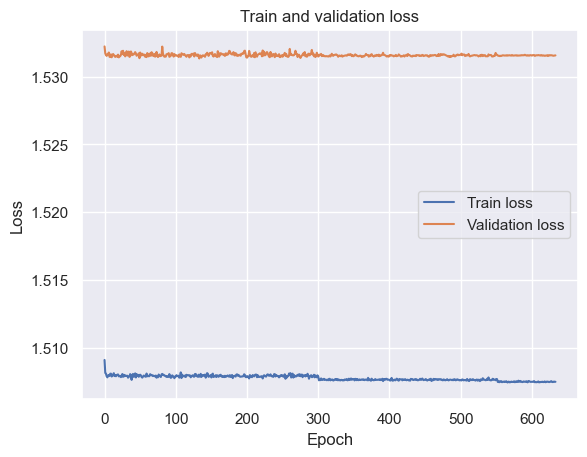

In [146]:
# Plot losses
sns.lineplot(x=range(len(train_losses)), y=train_losses, label="Train loss")
sns.lineplot(x=range(len(val_losses)), y=val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and validation loss")
plt.show()

## Evaluation

In [139]:
# Test model    
test_loss = test_model(model, test_loader, loss_fn, device=device)
print("Test loss: ", test_loss)

Test loss:  1.6121288855870566


In [140]:
def extract_Vs(Vs):
    # Eliminate the zeros at the end of the array
    Vs = Vs[Vs != 0]
    vs_soil = Vs[0]
    h_soil = len(Vs[:-2]) * 5
    vs_bedrock = Vs[-2]
    return vs_soil, vs_bedrock, h_soil

In [141]:
[extract_Vs(Vs) for Vs in X[:,0].cpu().numpy()]

IndexError: index -2 is out of bounds for axis 0 with size 1

In [ ]:
import scipy.stats as stats
def correlation_calc(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    batch_size = y_true.shape[0]
    corr = []

    assert y_true.shape[1] > 1, "Correlation can only be calculated for more than one value"

    # Calculate correlation for every batch
    for i in range(batch_size):
        corr.append(stats.pearsonr(y_true[i].flatten(), y_pred[i].flatten())[0])
    
    return np.array(corr)

In [396]:
# Show results
import scipy
model.eval()
target = []
predicted = []
Vs_soil = []
Vs_bedrock = []
h_soil = []
correlation = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        target.append(y.cpu().numpy())
        predicted.append(y_pred.cpu().numpy())
        Vs_soil_i, Vs_bedrock_i, h_soil_i = zip(*[extract_Vs(Vs) for Vs in X[:,0].cpu().numpy()])
        Vs_soil.append(Vs_soil_i)
        Vs_bedrock.append(Vs_bedrock_i)
        h_soil.append(h_soil_i)
        correlation.append(stats.pearsonr(y.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten())[0])

target = np.concatenate(target)
predicted = np.concatenate(predicted)
Vs_soil = np.concatenate(Vs_soil)
Vs_bedrock = np.concatenate(Vs_bedrock)
h_soil = np.concatenate(h_soil)
#correlation = np.concatenate(correlation)
correlation = np.array(correlation)

print(target.shape, predicted.shape, Vs_soil.shape, Vs_bedrock.shape, h_soil.shape, correlation.shape)

(150, 1, 1) (150, 1, 1) (150,) (150,) (150,) (3,)


ValueError: x and y must have same first dimension, but have shapes (200,) and (1, 1)

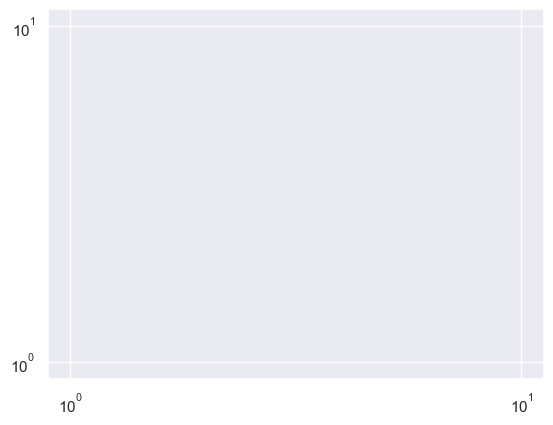

In [ ]:
for i in range(target.shape[0]):
    text_Vs = [Vs_soil[i], h_soil[i], Vs_bedrock[i]]
    plt.scatter(freq_data, target[i,:], label="Target")
    plt.scatter(freq_data, predicted[i,:], label="Predicted")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TF")
    plt.title("TF at Vs = " + str(text_Vs))
    plt.legend()
    plt.show()


In [121]:
Vs_soil.shape, h_soil.shape, Vs_bedrock.shape, correlation.shape

((150,), (150,), (150,), (150,))

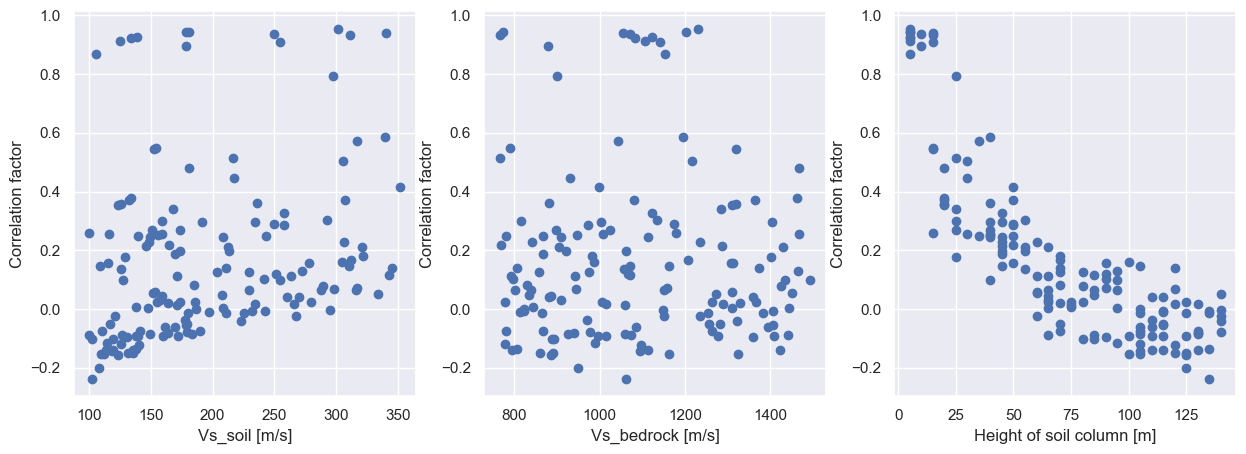

In [124]:
# Plot where x is Vs_soil, Vs_bedrock or height of soil column and y is correlation factor
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(Vs_soil, correlation)
ax[0].set_xlabel("Vs_soil [m/s]")
ax[0].set_ylabel("Correlation factor")

ax[1].scatter(Vs_bedrock, correlation)
ax[1].set_xlabel("Vs_bedrock [m/s]")
ax[1].set_ylabel("Correlation factor")

ax[2].scatter(h_soil, correlation)
ax[2].set_xlabel("Height of soil column [m]")
ax[2].set_ylabel("Correlation factor")

plt.show()